# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from igraph import Graph
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Rectangle

In [2]:
# %matplotlib notebook

# Helper function to get Bounding Box

In [3]:
def get_bb(coords, shape):
    bb = [0, 0, 0, 0]
    bb[0] = max(min(coords[0], coords[2]), 0)
    bb[1] = max(min(coords[1], coords[3]), 0)
    bb[2] = min(max(coords[0], coords[2]), shape[1])
    bb[3] = min(max(coords[1], coords[3]), shape[0])
    return bb

# Callback function to facilitate drawing

In [4]:
drawing = False
ix,iy = -1,-1
coords = [0, 0, 0, 0]
def draw(event,x,y,flags,param):
    global ix,iy,drawing,img,coords

    #start drawing
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix,iy = x,y
        coords[0], coords[1] = x, y

    #refresh
    elif event == cv2.EVENT_RBUTTONDOWN:
        img = cv2.imread(param[0])
        coords = [0, 0, 0, 0]
        cv2.imshow("image", img)
    
    #finish drawing
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        coords[2], coords[3] = x, y
        cv2.rectangle(img,(ix,iy),(x,y),(0,255,0),2)

# Main Functions

In [5]:
def get_graph(img, g, tu, tb, inds):
    
    h, wid = img.shape[:2]
    
    #left
    w = np.sum((img[:, 1:, :] - img[:, :-1, :])**2, axis=2).reshape((-1, 1))
    e = np.hstack((inds[:, 1:].reshape((-1, 1)), inds[:, :-1].reshape((-1, 1))))
    #top left
    w = np.vstack((w, np.sum((img[1:, 1:, :] - img[:-1, :-1, :])**2, axis=2).reshape((-1, 1))))
    e = np.vstack((e, np.hstack((inds[1:, 1:].reshape((-1, 1)), inds[:-1, :-1].reshape((-1, 1))))))
    #up
    w = np.vstack((w, np.sum((img[1:, :, :] - img[:-1, :, :])**2, axis=2).reshape((-1, 1))))
    e = np.vstack((e, np.hstack((inds[1:, :].reshape((-1, 1)), inds[:-1, :].reshape((-1, 1))))))
    #top right
    w = np.vstack((w, np.sum((img[1:, :-1, :] - img[:-1, 1:, :])**2, axis=2).reshape((-1, 1))))
    e = np.vstack((e, np.hstack((inds[1:, :-1].reshape((-1, 1)), inds[:-1, 1:].reshape((-1, 1))))))
    
    #finding beta and neighbour weights
    b = 1/(2*np.mean(w))
    n = np.ones((w.shape[0], 1))
    n[np.logical_and(np.abs(e[:, 0] - e[:, 1]) != 1, np.abs(e[:, 0] - e[:, 1]) != wid)] = np.sqrt(2)
    w = g * np.exp(-b * w)
    w /= n
    
    #defining source and terminal and their edges
    vs = h*wid
    vt = h*wid + 1
    nb = np.sum(tb)
    e = np.vstack((e, np.hstack((inds[tb].reshape((-1, 1)), np.ones((nb, 1))*vs ))))
    w = np.vstack((w, np.zeros((nb, 1))))
    e = np.vstack((e, np.hstack((inds[tb].reshape((-1, 1)), np.ones((nb, 1))*vt ))))
    w = np.vstack((w, 9 * g * np.ones((nb, 1))))
    
    return e, w
    

def grab_cut(img, bb, k, g, max_iter, title):
    
    # setting variables
    x1, y1, x2, y2 = bb
    h, wid = img.shape[:2]
    inds = np.arange(h*wid).reshape((h, wid))
    vs = h*wid
    vt = h*wid + 1
    
    # creating trimap
    tu = np.zeros((h, wid)).astype("bool")
    tu[y1:y2, x1:x2] = 1
    tb = np.ones((h, wid)).astype("bool")
    tb[y1:y2, x1:x2] = 0
    
    # defining GMMs
    fgmm = GaussianMixture(n_components=k)
    bgmm = GaussianMixture(n_components=k)
    
    #defining the graph
    e, w = get_graph(img, g, tu, tb, inds)

    #making variables to alter
    fgmask = deepcopy(tu)
    bgmask = deepcopy(tb)
    
    #running graphcut 
    for i in range(max_iter):
        
        # reinit
        te, tw = deepcopy(e), deepcopy(w)
        
        #fit the GMMs
        fgmm.fit(img[fgmask].reshape((-1, 3)))
        bgmm.fit(img[bgmask].reshape((-1, 3)))
        
        # find edge weights for unknowns
        nu = np.sum(fgmask)
        
        te = np.vstack((te, np.hstack((inds[fgmask].reshape((-1, 1)), np.ones((nu, 1))*vs ))))
        tw = np.vstack((tw, -bgmm.score_samples(img[fgmask].reshape((-1, 3))).reshape((-1, 1))))
        
        te = np.vstack((te, np.hstack((inds[fgmask].reshape((-1, 1)), np.ones((nu, 1))*vt ))))
        tw = np.vstack((tw, -fgmm.score_samples(img[fgmask].reshape((-1, 3))).reshape((-1, 1))))
        
        #creating a graph
        graph = Graph()
        graph.add_vertices(h*wid+2)
        graph.add_edges(te.astype("int"))
        graph.es['weight'] = tw.flatten()
        
        #mincut
        mincut = graph.mincut(wid*h, wid*h+1, capacity="weight")
        
        #new split
        bginds = np.array(mincut[1]).astype("int")
        bginds = bginds[bginds < h*wid]
        fginds = np.array(mincut[0]).astype("int")
        fginds = fginds[fginds < h*wid]
        
        bgmask = np.zeros(h*wid).astype("bool")
        bgmask[bginds] = 1
        bgmask = bgmask.reshape(h, wid)
        fgmask = np.zeros(h*wid).astype("bool")
        fgmask[fginds] = 1
        fgmask = fgmask.reshape(h, wid)
        
        #displaying the result
        res = deepcopy(img).reshape(-1, 3)
        res[bginds] = [0, 0, 0]
        res = res.reshape(h, wid, 3)
        fig, ax = plt.subplots(1)
        ax.imshow(res[:, :, ::-1])
        ax.title.set_text(title + " Iteration "+str(i+1))
        plt.show()

# Reading bounding boxes from files

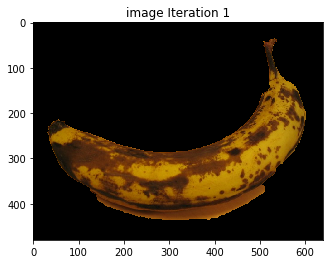

In [6]:
img = cv2.imread("../images/banana1.jpg")
with open("../bboxes/banana1.txt", 'r') as f:
    bb = np.array(f.readlines()[0].split(" ")).astype("int")
grab_cut(img, bb, 5, 500, 1, "image")

# Interactive GUI
- Press and hold the left mouse button to draw.
- Right click to refresh and start again.
- Press escape after drawing to continue.

## Variation with number of iterations

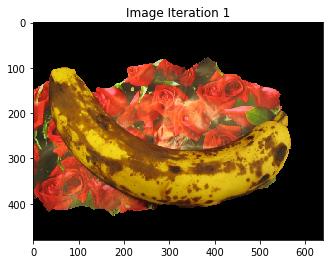

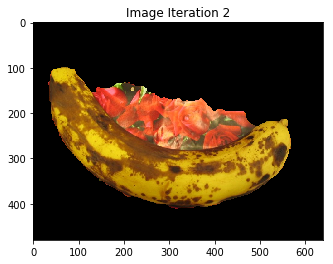

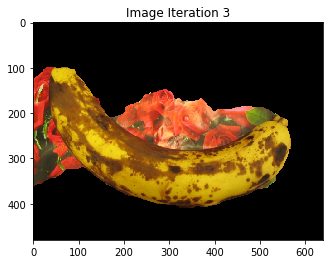

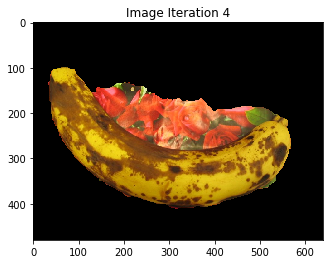

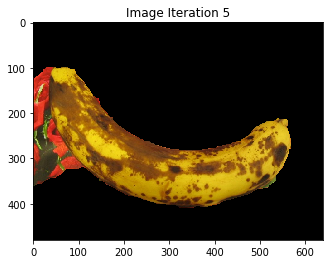

In [7]:
path = "../images/banana3.jpg"
img = cv2.imread(path)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw, param=[path])
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

img = cv2.imread(path)
bb = get_bb(coords, img.shape)
grab_cut(img, bb, 5, 100, 5, "Image")

## Variation with colour space

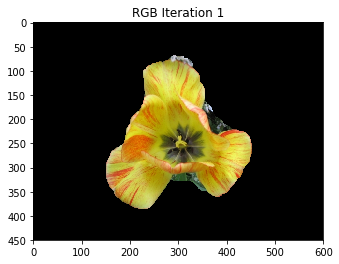

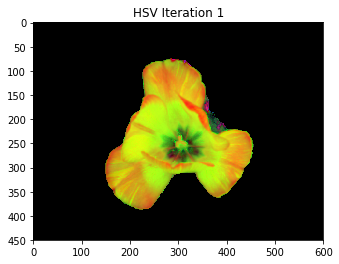

In [7]:
path = "../images/flower.jpg"
img = cv2.imread(path)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw, param=[path])
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

bb = get_bb(coords, img.shape)
img = cv2.imread(path)
grab_cut(img, bb, 5, 100, 1, "RGB")
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
grab_cut(img, bb, 5, 100, 1, "HSV")

## Variation with gamma

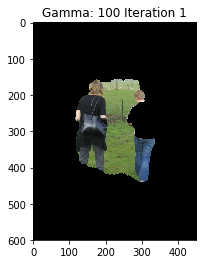

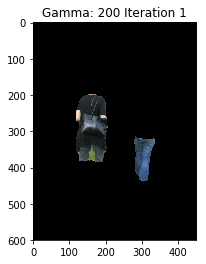

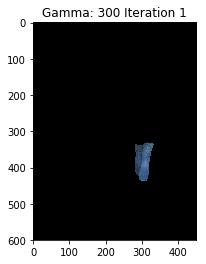

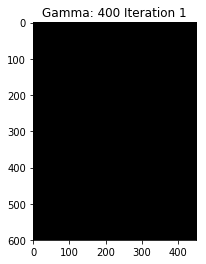

In [8]:
path = "../images/person5.jpg"
img = cv2.imread(path)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw, param=[path])
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

bb = get_bb(coords, img.shape)
img = cv2.imread(path)
grab_cut(img, bb, 5, 100, 1, "Gamma: 100")
grab_cut(img, bb, 5, 200, 1, "Gamma: 200")
grab_cut(img, bb, 5, 300, 1, "Gamma: 300")
grab_cut(img, bb, 5, 400, 1, "Gamma: 400")

## Variation with number of components

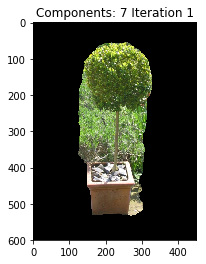

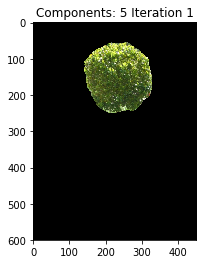

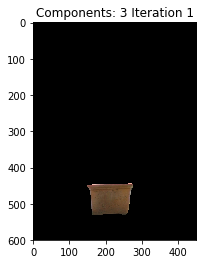

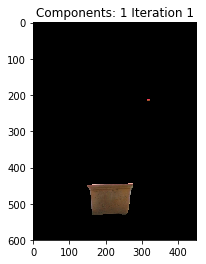

In [9]:
path = "../images/bush.jpg"
img = cv2.imread(path)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw, param=[path])
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

bb = get_bb(coords, img.shape)
img = cv2.imread(path)
grab_cut(img, bb, 7, 80, 1, "Components: 7")
grab_cut(img, bb, 5, 80, 1, "Components: 5")
grab_cut(img, bb, 3, 80, 1, "Components: 3")
grab_cut(img, bb, 1, 80, 1, "Components: 1")

## Results on images from camera

In [ ]:
path = "../images/camera.jpg"
img = cv2.imread(path)
cv2.namedWindow('image')
cv2.setMouseCallback('image', draw, param=[path])
while(1):
    cv2.imshow('image',img)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

img = cv2.imread(path)
bb = get_bb(coords, img.shape)
grab_cut(img, bb, 5, 200, 1, "Camera")